In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pickle

In [2]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit, train_test_split, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [3]:
from dask import dataframe as dd
import joblib
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.scheduler, cluster.workers

C:\Users\bwils\anaconda3\envs\micromotion\lib\site-packages\distributed\node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 59815 instead
  warnings.warn(


(<Scheduler: "tcp://127.0.0.1:59818" processes: 3 cores: 6>,
 {0: <Nanny: tcp://127.0.0.1:59843, threads: 2>,
  1: <Nanny: tcp://127.0.0.1:59837, threads: 2>,
  2: <Nanny: tcp://127.0.0.1:59838, threads: 2>})

In [4]:
train_X = pd.read_pickle('DFs/train_test/train_X.pkl')
train_y = pd.read_pickle('DFs/train_test/train_y.pkl')
test_X = pd.read_pickle('DFs/train_test/test_X.pkl')
test_y = pd.read_pickle('DFs/train_test/test_y.pkl')

In [5]:
f = open(r'DFs/train_test/participants.pkl', 'rb')
participants = pickle.load(f)
f.close()

In [6]:
%%writefile model_prep/score.py
def score_model(model, participants, test_y, test_X, log, model_name='Model'):
    
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_percentage_error
    import pandas as pd
    import numpy as np
    
    par_scores = {'par':[],'pred':[], 'true':[],'MAPE':[]}
    for par in participants['test']:
        mask = test_y.reset_index(drop=True)['PID']==par
        pred_X = test_X[mask,:]
        y_pred = model.predict(pred_X)
        y_true = test_y.loc[test_y['PID']==par, 'target_1_sec'].to_numpy()
        par_scores['par'].append(par)
        par_scores['pred'].append(y_pred)
        par_scores['true'].append(y_true)
    
        MAPE = mean_absolute_percentage_error(y_true, y_pred)
        MAE = mean_absolute_error(y_true, y_pred)
        par_scores['MAPE'].append(MAPE)
        
        log['par'].append(par)
        log['MAPE'].append(MAPE)
        log['MAE'].append(MAE)
        log['model'].append(model_name)
        for key, value in model.get_params().items():
            log[key].append(value)
        
        
        par_scores_df = pd.DataFrame(par_scores)   
    return par_scores_df, log    

Overwriting model_prep/score.py


In [7]:
%%writefile model_prep/predict.py
def plot_predictions(results, participants, model_name='Model'):
    
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    ind = 0
    for par in participants['test']:
        prediction = results.loc[results['par']==par, 'pred'][ind]
        truth = results.loc[results['par']==par, 'true'][ind]
        compare = pd.DataFrame({'Truth':truth, 'Prediction':prediction})
        compare.rolling(100).mean().plot(figsize=(20,6))
        plt.title('{model} Comparision of Actual to Proposed Participant {par}'.format(model=model_name, par=par))
        plt.xlabel('Time (tenths of a second)')
        plt.ylabel('Movement (mm)')
        plt.text(x=1750, y=5.5, s='MAPE = {}%'.format(int(results['MAPE'][ind]*100)), fontsize='x-large')
        plt.ylim(1,7)
        plt.show()
        ind +=1

Overwriting model_prep/predict.py


In [8]:
from model_prep import score_model

In [9]:
from model_prep import plot_predictions

# ElasticNet 10 Components

In [10]:
elastic10 = ElasticNet()
pca10 = PCA(n_components=10)
train_X_pca10 = pca10.fit_transform(train_X)
test_X_pca10 = pca10.transform(test_X)
elastic10.fit(train_X_pca10, train_y)

ElasticNet()

In [11]:
elastic_scores = {'model':[],'par':[],'MAPE':[], 'MAE':[]}
for param in elastic10.get_params():
    elastic_scores[param]=[]

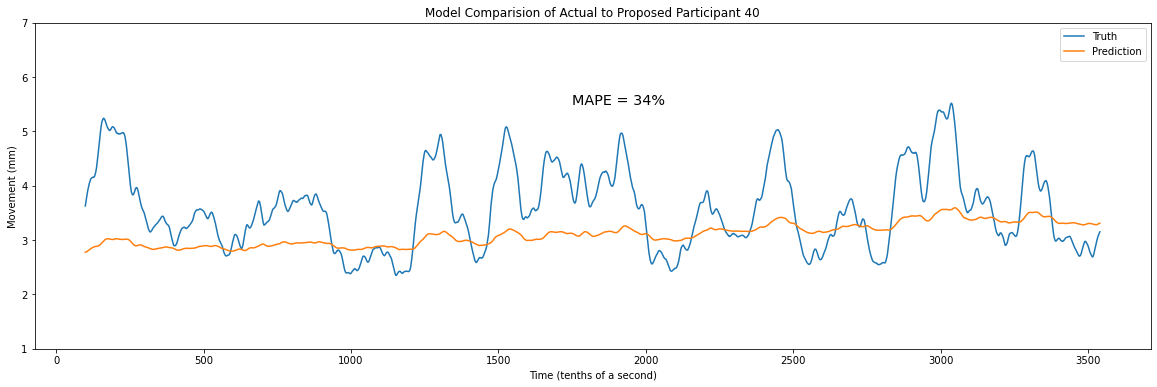

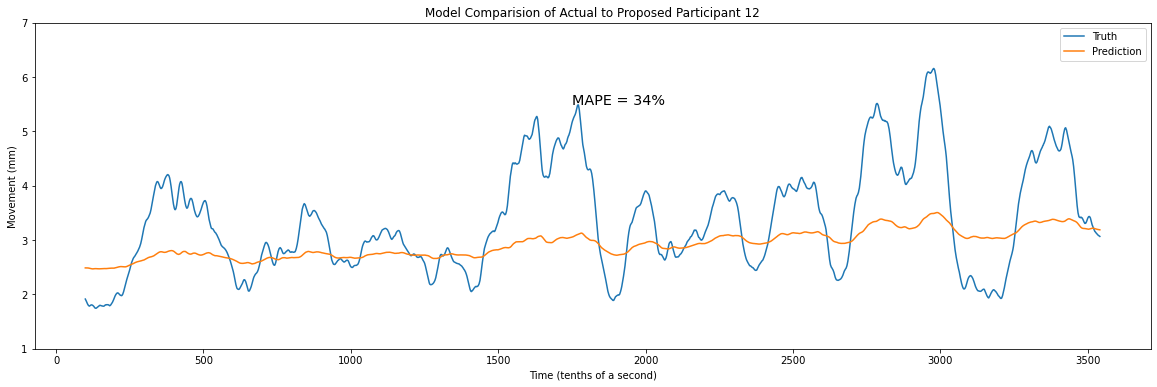

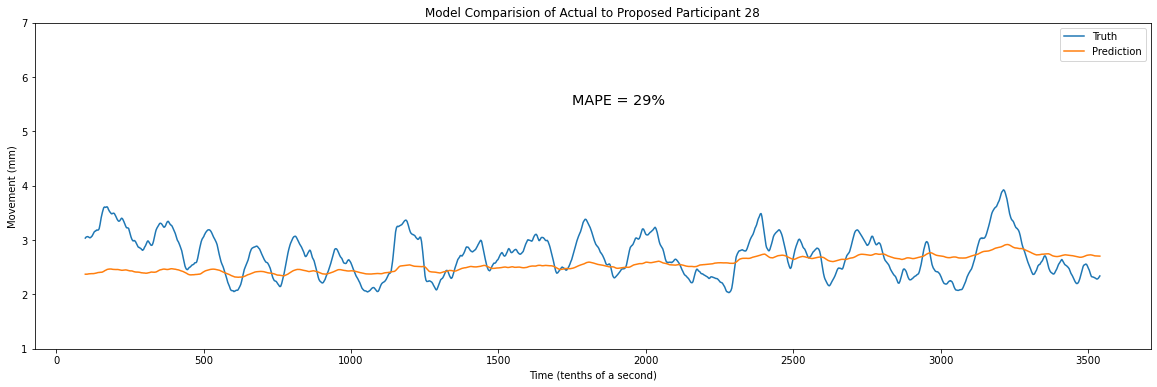

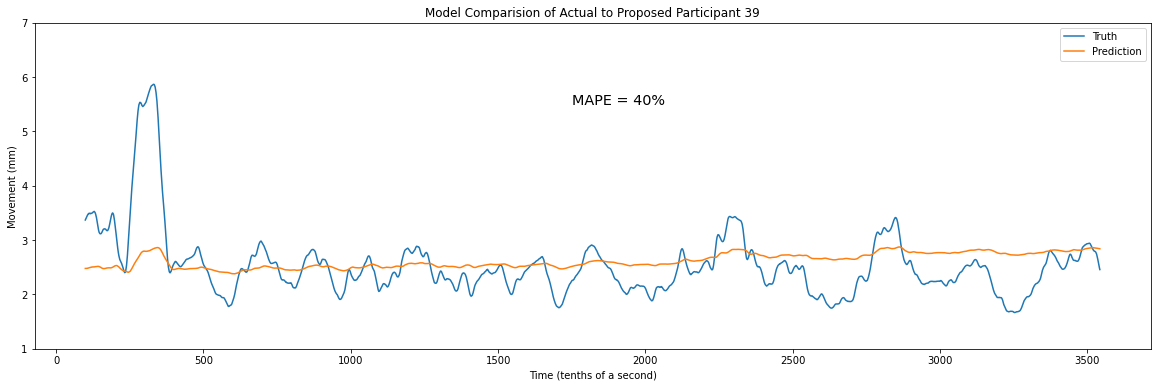

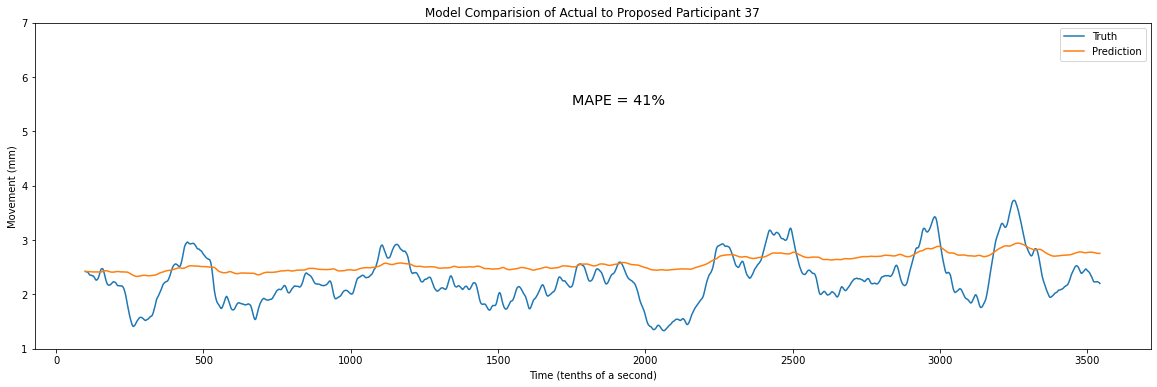

In [12]:
results, elastic_scores = score_model(elastic10, participants=participants, test_y=test_y, test_X=test_X_pca10, 
                      model_name='ElasticNet10', log = elastic_scores)
plot_predictions(results, participants)

In [13]:
elastic_scores.keys()

dict_keys(['model', 'par', 'MAPE', 'MAE', 'alpha', 'copy_X', 'fit_intercept', 'l1_ratio', 'max_iter', 'normalize', 'positive', 'precompute', 'random_state', 'selection', 'tol', 'warm_start'])

# ElasticNet 200 Components

In [14]:
elastic200 = ElasticNet()
pca200 = PCA(n_components=200)
train_X_pca200 = pca200.fit_transform(train_X)
test_X_pca200 = pca200.transform(test_X)
elastic200.fit(train_X_pca200, train_y)

ElasticNet()

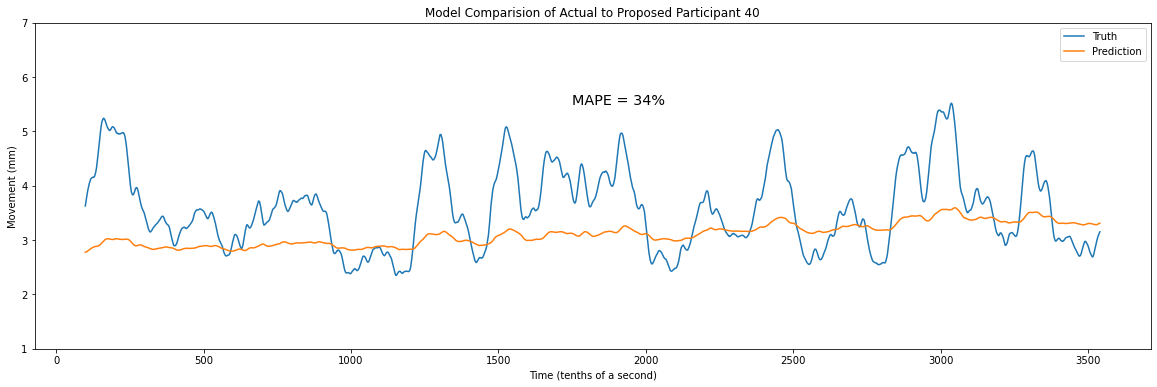

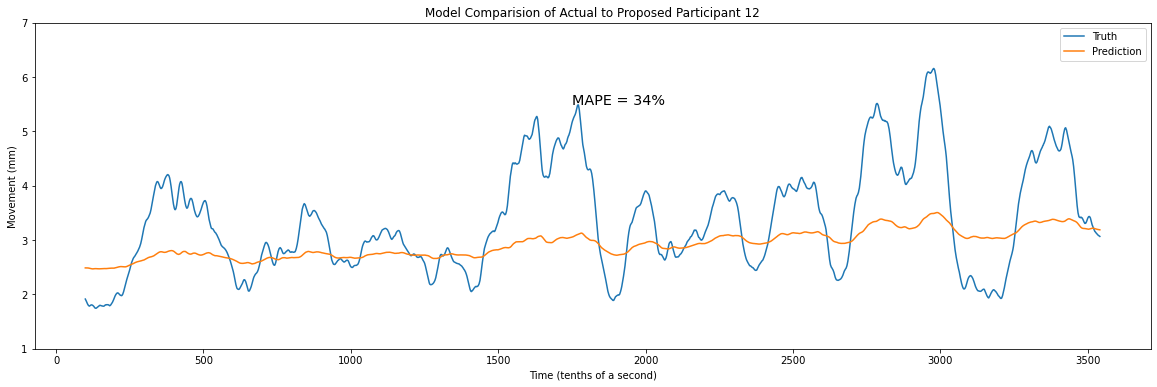

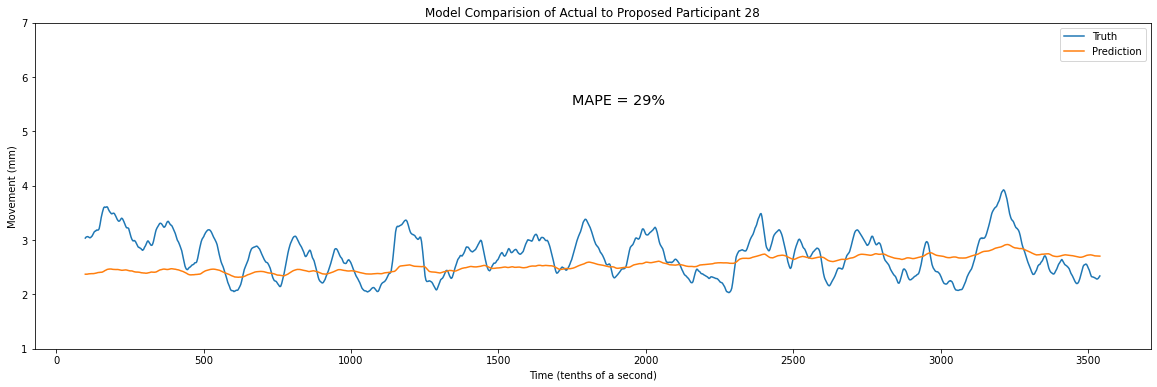

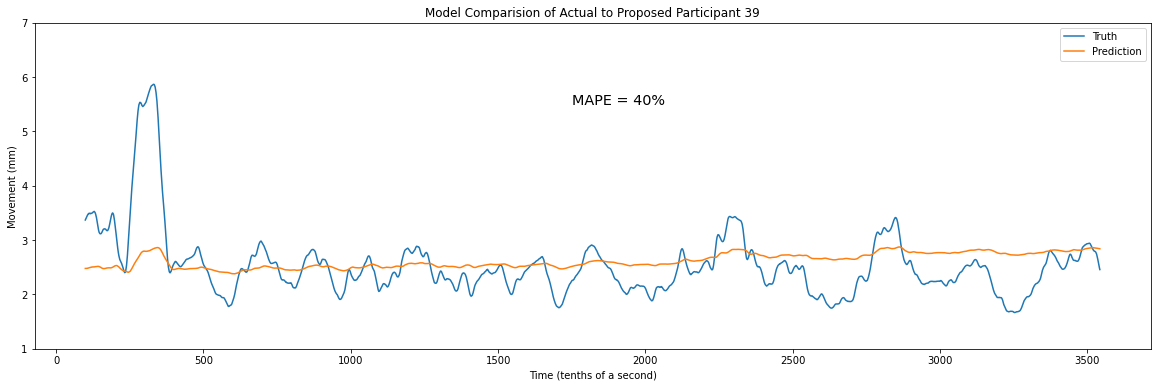

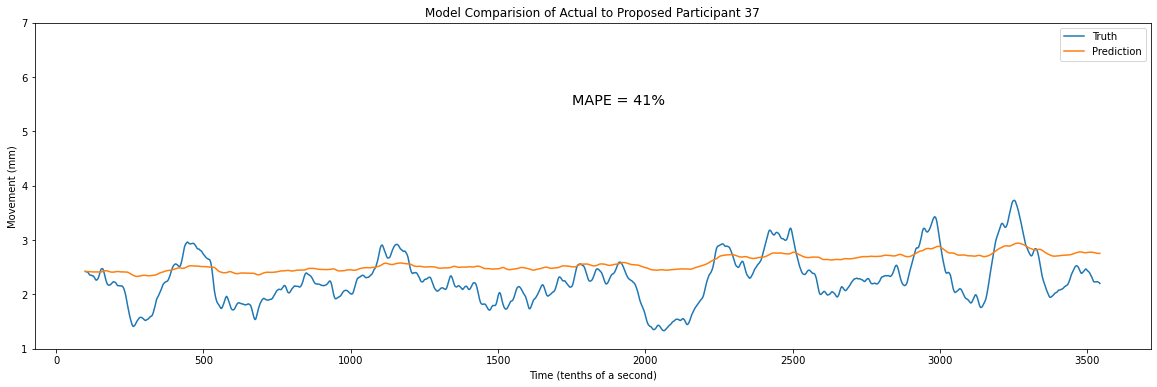

In [15]:
results, elastic_scores = score_model(elastic200, participants=participants, test_y=test_y, test_X=test_X_pca200, 
                     model_name='Elastic200', log = elastic_scores)
plot_predictions(results, participants)

# ElasticNet All Components

In [16]:
elastic = ElasticNet()
elastic.fit(train_X, train_y)

ElasticNet()

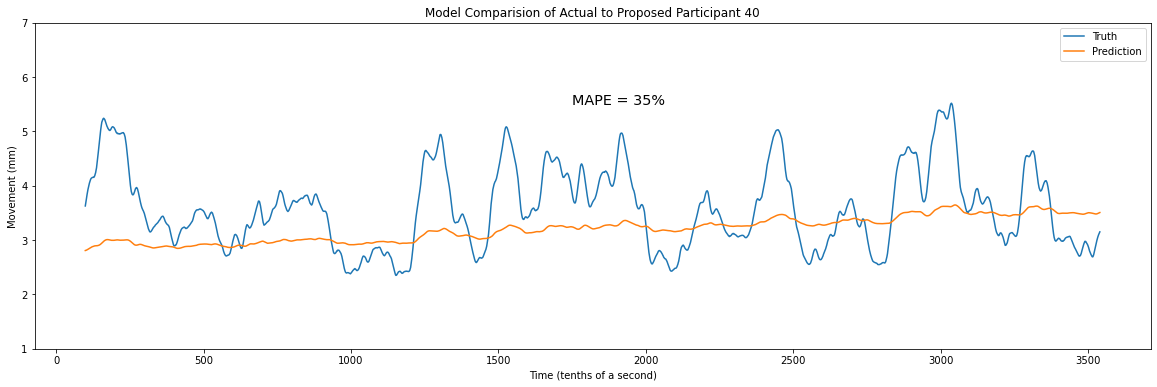

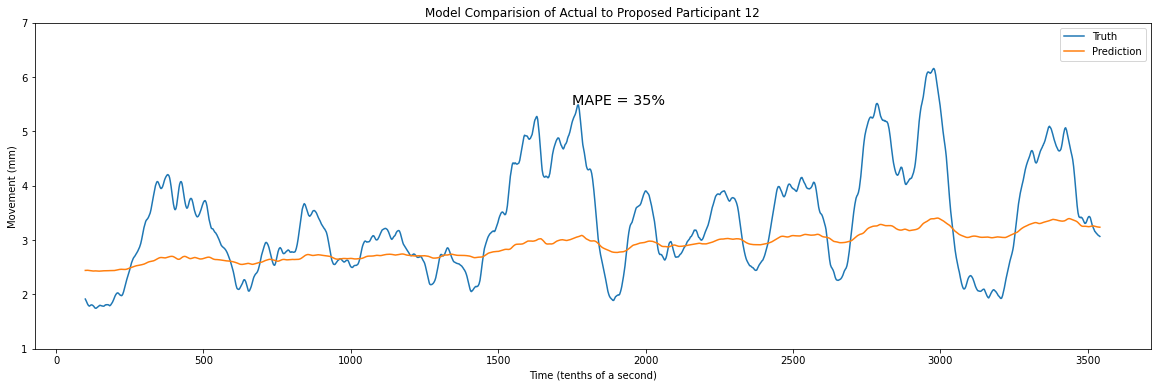

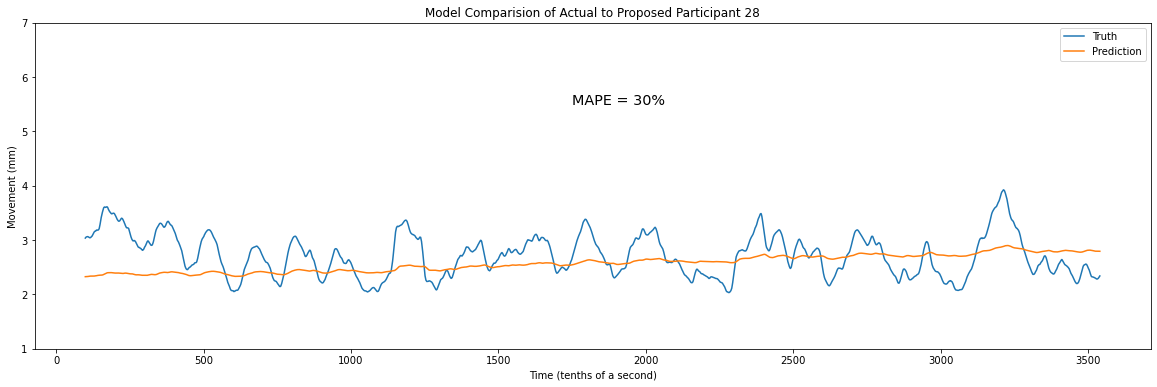

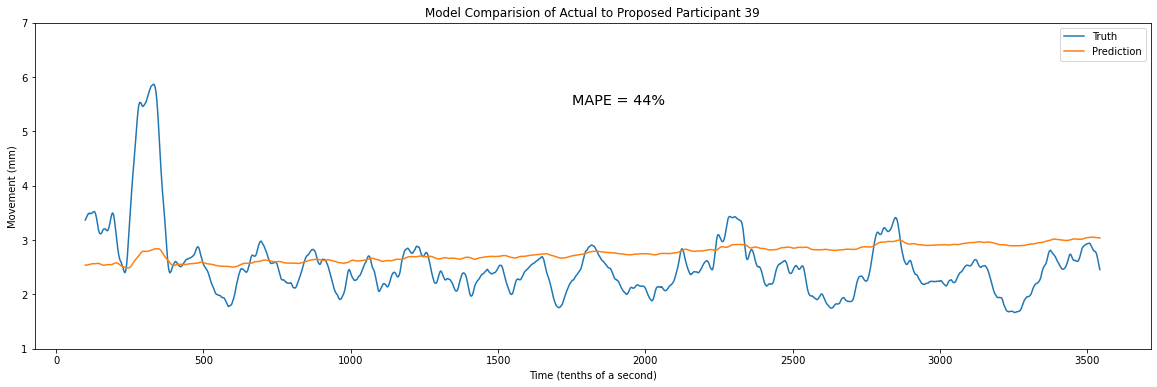

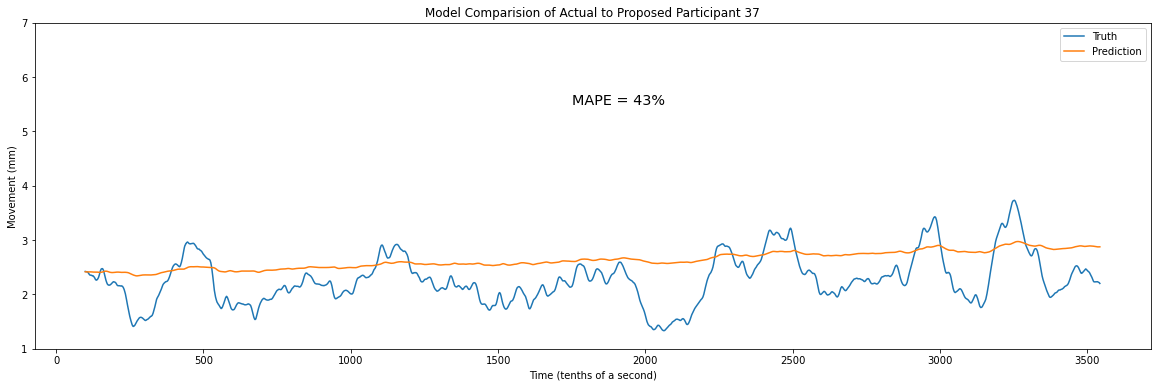

In [17]:
results, elastic_scores = score_model(elastic, participants=participants, test_y=test_y, test_X=test_X.to_numpy(), 
                     model_name='ElasticAll', log = elastic_scores)
plot_predictions(results, participants)

In [18]:
elastic_df = pd.DataFrame(elastic_scores)

In [19]:
elastic_df.groupby(['par','model']).mean()

MAPE       MAE  alpha  copy_X  fit_intercept  l1_ratio  \
par model                                                                      
12  Elastic200    0.348419  1.089714    1.0    True           True       0.5   
    ElasticAll    0.351624  1.107409    1.0    True           True       0.5   
    ElasticNet10  0.348419  1.089714    1.0    True           True       0.5   
28  Elastic200    0.299234  0.737587    1.0    True           True       0.5   
    ElasticAll    0.306322  0.747784    1.0    True           True       0.5   
    ElasticNet10  0.299234  0.737587    1.0    True           True       0.5   
37  Elastic200    0.416724  0.743369    1.0    True           True       0.5   
    ElasticAll    0.439064  0.775630    1.0    True           True       0.5   
    ElasticNet10  0.416724  0.743369    1.0    True           True       0.5   
39  Elastic200    0.403804  0.838548    1.0    True           True       0.5   
    ElasticAll    0.445298  0.889052    1.0    True           True       0.5   
    ElasticNet10  0.403804  0.838548    1.0    True           True       0.5   
40  Elastic200    0.341926  1.164982    1.0    True           True       0.5   
    ElasticAll    0.355671  1.174097    1.0    True           True       0.5   
    ElasticNet10  0.341926  1.164982    1.0    True           True       0.5   

                  max_iter  normalize  positive  precompute     tol  \
par model                                                             
12  Elastic200        1000      False     False       False  0.0001   
    ElasticAll        1000      False     False       False  0.0001   
    ElasticNet10      1000      False     False       False  0.0001   
28  Elastic200        1000      False     False       False  0.0001   
    ElasticAll        1000      False     False       False  0.0001   
    ElasticNet10      1000      False     False       False  0.0001   
37  Elastic200        1000      False     False       False  0.0001   
    ElasticAll        1000      False     False       False  0.0001   
    ElasticNet10      1000      False     False       False  0.0001   
39  Elastic200        1000      False     False       False  0.0001   
    ElasticAll        1000      False     False       False  0.0001   
    ElasticNet10      1000      False     False       False  0.0001   
40  Elastic200        1000      False     False       False  0.0001   
    ElasticAll        1000      False     False       False  0.0001   
    ElasticNet10      1000      False     False       False  0.0001   

                  warm_start  
par model                     
12  Elastic200         False  
    ElasticAll         False  
    ElasticNet10       False  
28  Elastic200         False  
    ElasticAll         False  
    ElasticNet10       False  
37  Elastic200         False  
    ElasticAll         False  
    ElasticNet10       False  
39  Elastic200         False  
    ElasticAll         False  
    ElasticNet10       False  
40  Elastic200         False  
    ElasticAll         False  
    ElasticNet10       False

In [20]:
elastic_df.to_pickle(r'DFs/scores/elastic.pkl')